In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
signal_points = [ Tree(fn) for fn in fc.sr.NMSSM_List ]
bkg_tree = Tree( fc.sr.QCD_B_List+[fc.sr.TTJets])

In [3]:
for point in signal_points:
    mx=int(ak.mean(point["gen_X_m"]))
    my=int(ak.mean(point["gen_Y_m"]))
    point.sample = f"Mx{mx}_My{my}"
    if not (mx==700 and my==400): point.color = None

In [4]:
def count_all_higgs(jet_signalId):
    has_hx = (ak.any(jet_signalId == 0,axis=-1) & ak.any(jet_signalId == 1,axis=-1))
    has_h1y = (ak.any(jet_signalId == 2,axis=-1) & ak.any(jet_signalId == 3,axis=-1))
    has_h2y = (ak.any(jet_signalId == 4,axis=-1) & ak.any(jet_signalId == 5,axis=-1))

    nhiggs = 1*has_hx + 1*has_h1y + 1*has_h2y
    return nhiggs

In [5]:
for tree in signal_points:
    tree.extend(
        nfound_nn_all_h = count_all_higgs(tree.nn_jet_signalId),
        nfound_t6_all_h = count_all_higgs(tree.t6_jet_signalId)
    )

    tree.extend(
        nn_6j_eff=safe_divide(tree.nfound_nn,tree.nfound_presel,default=1), 
        nn_3d_eff=safe_divide(tree.nfound_nn_h,tree.nfound_nn_all_h,default=1),
        nn_invm0_eff=safe_divide(tree.nn_invm0,tree.gen_X_m,default=1), 
        nn_invm0_diff=tree.gen_X_m-tree.nn_invm0, 
        
        t6_eff=safe_divide(tree.nfound_t6,tree.nfound_presel,default=1), 
        d_hhh_eff=safe_divide(tree.nfound_t6_h,tree.nfound_t6_all_h,default=1),
        t6_invm0_eff=safe_divide(tree.t6_invm0,tree.gen_X_m,default=1), 
        t6_invm0_diff=tree.gen_X_m-tree.t6_invm0, 
    )

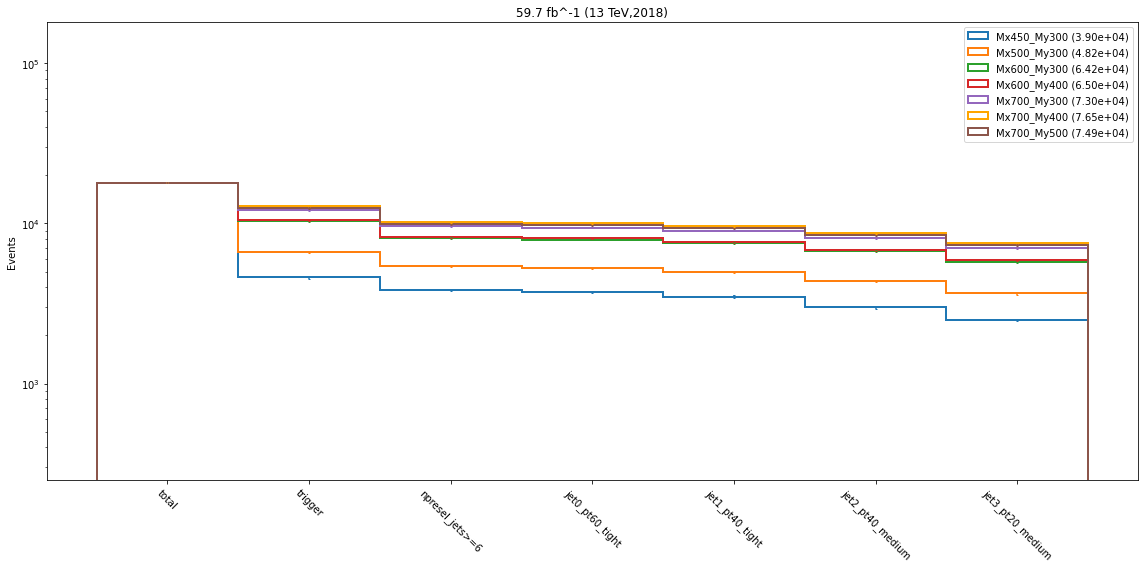

In [6]:
study.cutflow(signal_points)

In [13]:
def graph_signal(ydata,ylabel=None,xlabels=[point.sample for point in signal_points],figax=None):
    fig,ax = graph_multi(range(7),ydatalist=[ydata[:,0]],yerrs=[ydata[:,1]],ylabel=ylabel,figax=figax)
    ax.set_xticks(list(range(7)))
    ax.set_xticklabels([point.sample for point in signal_points],rotation=45);
    return fig,ax

In [8]:
def get_avg_std(array):
    array = array[~np.isnan(array)]
    avg = ak.mean(array)
    std = ak.std(array)
    return avg,std

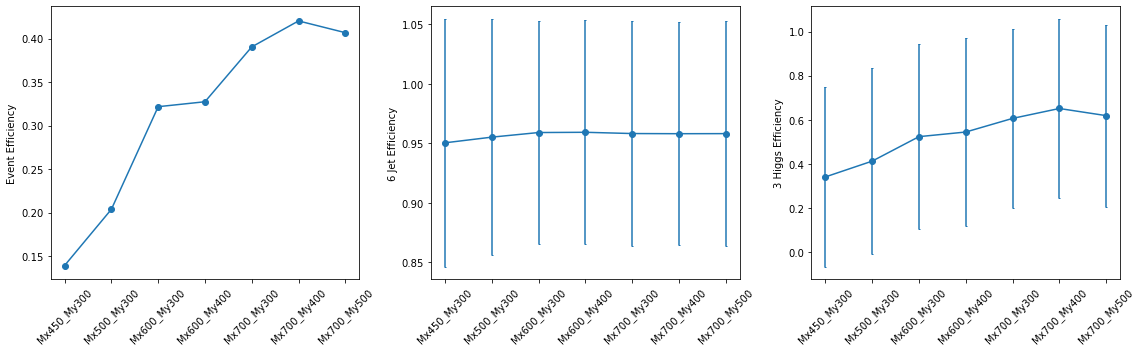

In [16]:
def event_eff(tree,ncut=-1):
    cutflow = ak.sum(tree.cutflow,axis=0)
    eff = cutflow[ncut]/cutflow[0]
    err = eff*np.sqrt(1/cutflow[ncut]+1/cutflow[0])
    return (eff,err) 

fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(16,5))
    
sp_data = np.array([ event_eff(point) for point in signal_points ])
graph_signal(sp_data,ylabel="Event Efficiency",figax=(fig,axs[0]));
sp_data = np.array([ get_avg_std(point.nn_6j_eff) for point in signal_points ])
graph_signal(sp_data,ylabel="6 Jet Efficiency",figax=(fig,axs[1]));
sp_data = np.array([ get_avg_std(point.nn_3d_eff) for point in signal_points ])
graph_signal(sp_data,ylabel="3 Higgs Efficiency",figax=(fig,axs[2]));

fig.tight_layout()

In [10]:
varinfo.nfound_presel = dict(bins=range(8),xlabel="N Presel Signal Jets")
varinfo.nfound_nn = dict(bins=range(8),xlabel="N NN6j Signal Jets")
varinfo.nn_6j_eff = dict(bins=None,xlabel="NN6j Signal Jet Eff")
varinfo.nfound_t6 = dict(bins=range(8),xlabel="N T6j Signal Jets")
varinfo.t6_eff = dict(bins=None,xlabel="T6j Signal Jet Eff")

varinfo.nfound_presel_h = dict(bins=range(5),xlabel="N Presel Higgs")
varinfo.nfound_nn_all_h = dict(bins=range(5),xlabel="N NN6j Higgs")
varinfo.nfound_nn_h = dict(bins=range(5),xlabel="N NN3d Higgs")
varinfo.nfound_t6_all_h = dict(bins=range(5),xlabel="N T6j Higgs")
varinfo.nfound_t6_h = dict(bins=range(5),xlabel="N DHHH Higgs")
varinfo.nn_3d_eff = dict(bins=None,xlabel="NN3d Higgs Eff")
varinfo.d_hhh_eff = dict(bins=None,xlabel="DHHH Signal Jet Eff")

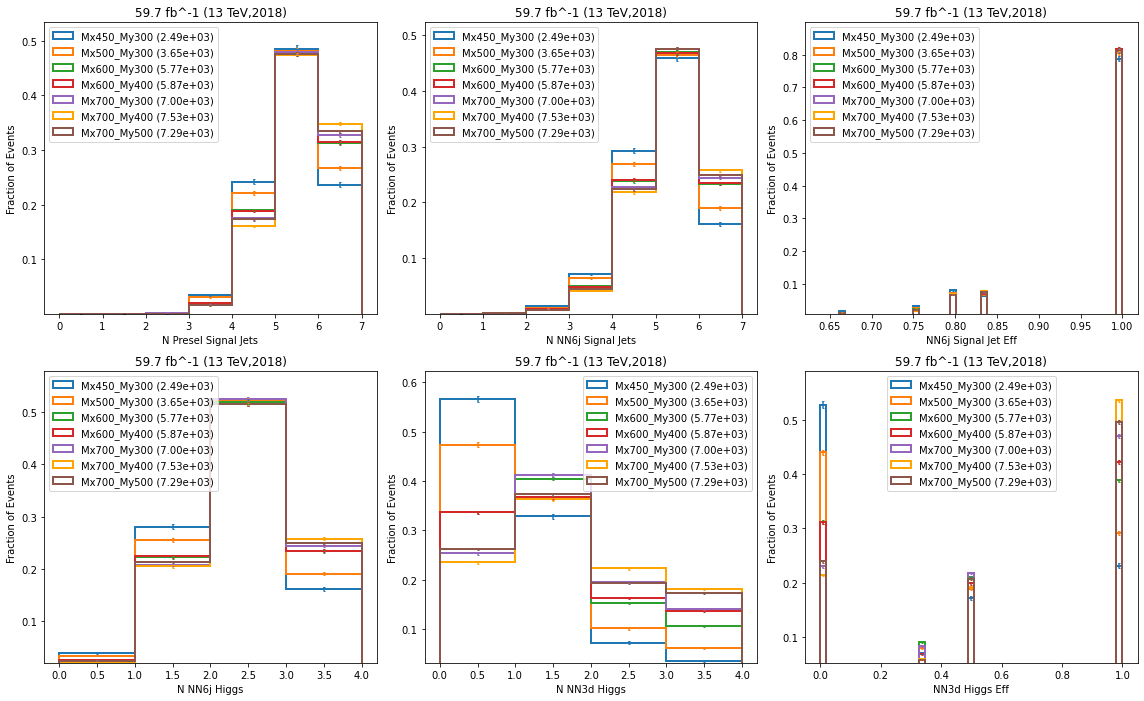

In [11]:
study.quick(signal_points, varlist=["nfound_presel", "nfound_nn",
            "nn_6j_eff", "nfound_nn_all_h", "nfound_nn_h", "nn_3d_eff"], dim=(2, 3), density=1)
# study.quick(signal_points, varlist=["nfound_presel", "nfound_t6",
#             "t6_eff", "nfound_presel_h", "nfound_t6_h", "d_hhh_eff"], dim=(2, 3), density=1)


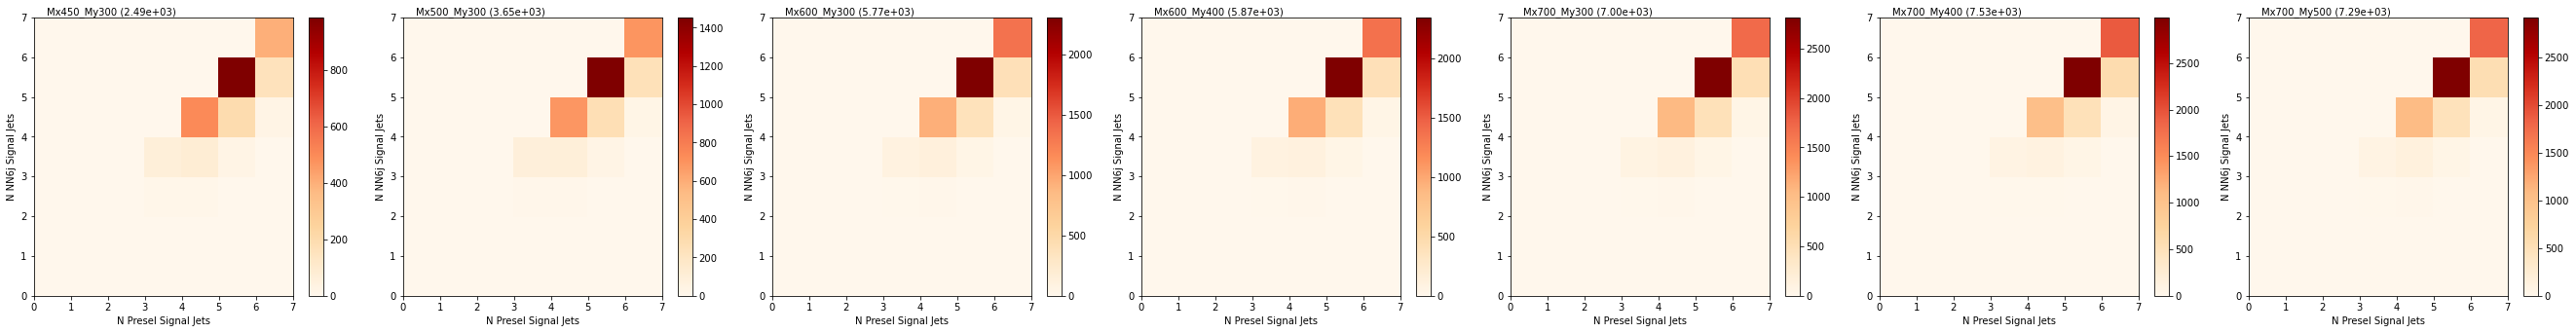

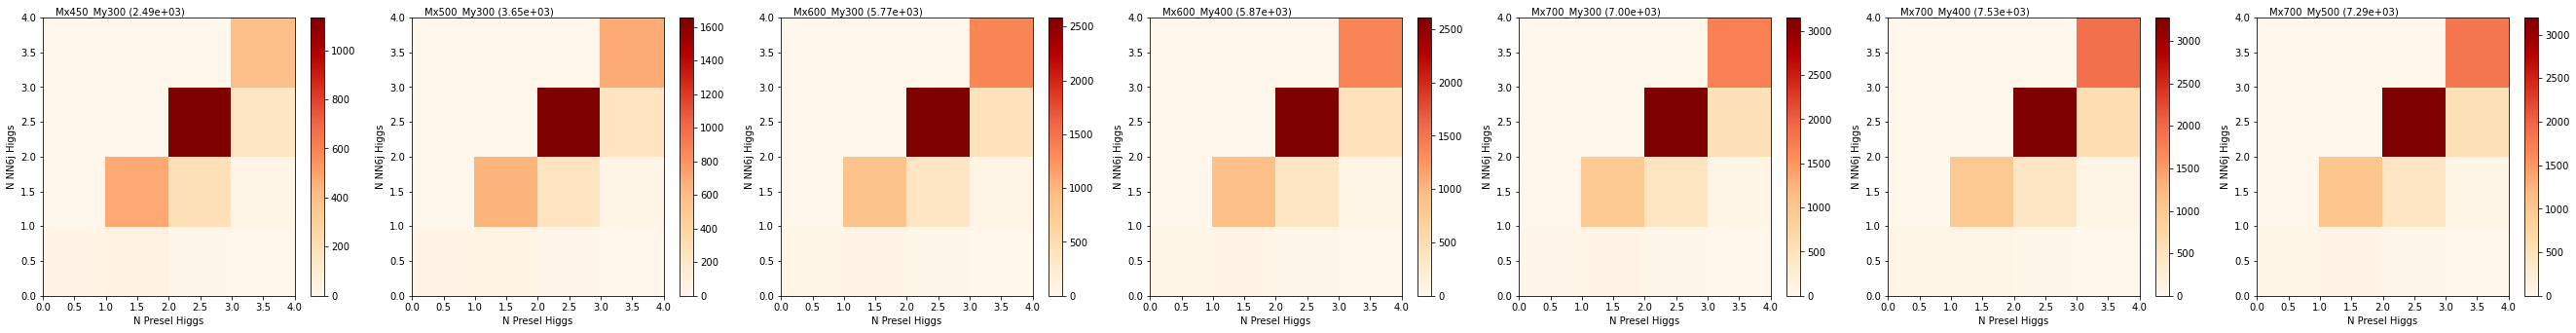

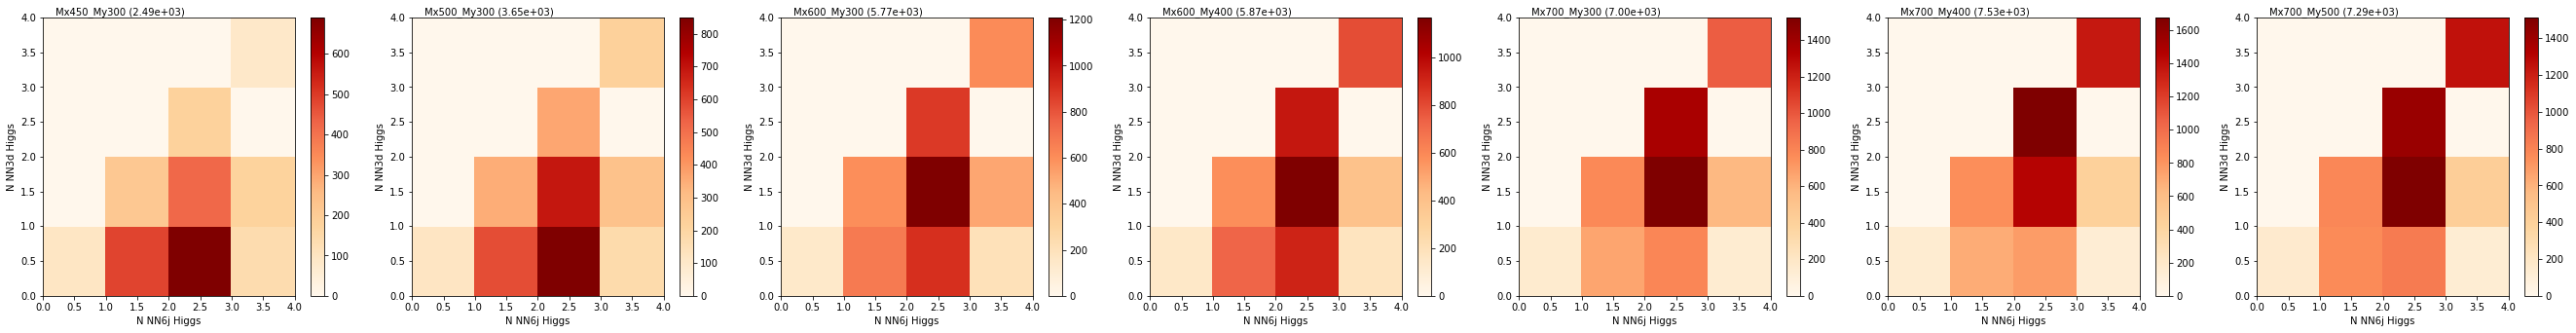

In [12]:
study.quick2d(signal_points,varlist=["nfound_presel","nfound_nn"],dim=(1,7),cmap='OrRd')
study.quick2d(signal_points,varlist=["nfound_presel_h","nfound_nn_all_h"],dim=(1,7),cmap='OrRd')
study.quick2d(signal_points,varlist=["nfound_nn_all_h","nfound_nn_h"],dim=(1,7),cmap='OrRd')